![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [2]:
import numpy as np
data = np.load("/content/drive/My Drive/AIML/images.npy",allow_pickle=True)

In [3]:
data.shape

(409, 2)

### Check one sample from the loaded "images.npy" file  (2 marks)
- Hint: print data[10][1] 

In [4]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [5]:
IMAGE_HEIGHT=224
IMAGE_WIDTH=224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [6]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing (2 marks)
- 400 images in training
- 9 images in testing data

Training data

In [7]:
X_train = X[:400]
y_train = masks[:400]

Testing data

In [8]:
X_test = X[400:]
y_test = masks[400:]

### Print a sample training image, image array and its mask (2 marks)

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


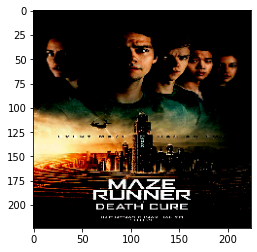

In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[11])

Print the mask

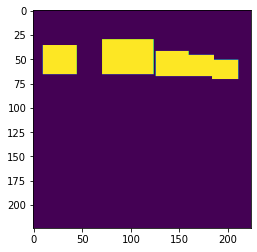

In [10]:
plt.imshow(y_train[11])

## Create the model (5 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [11]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block0 = model.get_layer("conv_pw_1_relu").output 
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    print(x.shape)

    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)

    return Model(model.input, outputs=x)

### Call the create_model function (1 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [12]:
model = create_model()

17227776/17225924 [==============================] - 0s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224, 1)
(None, 224, 224)


### Print model summary (1 mark)

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

### Define dice coefficient function (2 marks)
- Create a function to calculate dice coefficient


In [14]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import epsilon

def calc_dice_coef(y_true,y_pred):
  intersection = reduce_sum(y_true * y_pred)
  denominator = reduce_sum(y_true+y_pred)
  return (2*intersection) / (denominator + epsilon())

### Define loss function (2 marks)

In [15]:
#### Add your code here ####
def dice_loss(y_true,y_pred):

  return 1 - calc_dice_coef(y_true,y_pred)

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [16]:
#### Add your code here ####
model.compile(loss = dice_loss, optimizer="adam", metrics=[calc_dice_coef])

### Define callbacks (2 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [17]:
#### Add your code here ####
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

mc = ModelCheckpoint(mode = 'min', filepath='checkpoint.h5', monitor='loss', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode = 'min', monitor='loss', patience=5, verbose=1)
lop = ReduceLROnPlateau(mode = 'min', monitor='loss', factor=0.2, patience=2, min_lr=0.01)


### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [18]:
#### Add your code here ####
model.fit(X_train,y_train,epochs=10,batch_size=1,callbacks=[mc,lop,es])

Epoch 1/10
399/400 [============================>.] - ETA: 0s - loss: 0.5048 - calc_dice_coef: 0.4952
Epoch 00001: loss improved from inf to 0.50455, saving model to checkpoint.h5
400/400 [==============================] - 19s 46ms/step - loss: 0.5045 - calc_dice_coef: 0.4955
Epoch 2/10
399/400 [============================>.] - ETA: 0s - loss: 0.4160 - calc_dice_coef: 0.5840
Epoch 00002: loss improved from 0.50455 to 0.41651, saving model to checkpoint.h5
400/400 [==============================] - 19s 47ms/step - loss: 0.4165 - calc_dice_coef: 0.5835
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.3955 - calc_dice_coef: 0.6045
Epoch 00003: loss improved from 0.41651 to 0.39549, saving model to checkpoint.h5
400/400 [==============================] - 19s 47ms/step - loss: 0.3955 - calc_dice_coef: 0.6045
Epoch 4/10
399/400 [============================>.] - ETA: 0s - loss: 0.3664 - calc_dice_coef: 0.6336
Epoch 00004: loss improved from 0.39549 to 0.36701, saving 

### Get the predicted mask for a test image   (2 marks)

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


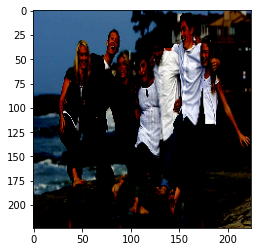

In [19]:
#### Add your code here ####
plt.imshow(X_test[2])

Show original mask for test image

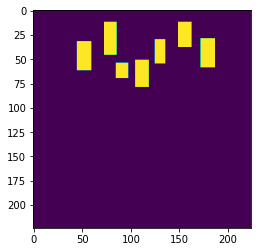

In [20]:
plt.imshow(y_test[2])

Predict the mask on the test image

In [21]:
#### Add your code here ####
m=2
y_pred=model.predict(X_test)

### Impose the mask on the test image (2 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


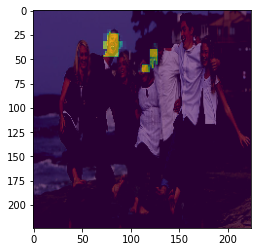

In [23]:
#### Add your code here ####
plt.imshow(X_test[m])
plt.imshow(y_pred[m],alpha=0.60)